In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/"

/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE


## Requirements

In [3]:
# Transformers installation
! pip install transformers
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git


     |████████████████████████████████| 4.0 MB 8.4 MB/s 
     |████████████████████████████████| 895 kB 51.7 MB/s 
     |████████████████████████████████| 77 kB 8.7 MB/s 
     |████████████████████████████████| 596 kB 62.0 MB/s 
     |████████████████████████████████| 6.6 MB 57.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import torch

In [6]:
MODELNAME = 'biodivbert-abstracts'
DATASETNAME = 'euadr'

In [7]:
MODEL_PATH = "/content/drive/My Drive/Colab Notebooks/BiodivBERT-NER/models/biodivbert-abstracts"

In [8]:
tokenizer_name = 'bert-base-cased'

In [9]:
num_train_epochs = 5

In [10]:
MODEL_PATH

'/content/drive/My Drive/Colab Notebooks/BiodivBERT-NER/models/biodivbert-abstracts'

In [11]:
num_train_epochs

5

## Dataset Preprocessing


Dataset config file

In [12]:
root_dir = "/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/"

root_data_dir = os.path.join(root_dir, "datasets", "euadr")
print(root_data_dir)

/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/datasets/euadr


Data loading utils

In [13]:
def loadData(csv_file_path, header=None, index_col=None):
  dataset_path = os.path.join(root_data_dir, csv_file_path)
  data = pd.read_csv(dataset_path, encoding="latin1", sep=',', header=header, index_col=index_col)
  data = data.fillna(method="ffill")
  return data

In [14]:
data_train = loadData(csv_file_path='train.csv', header=0, index_col=None)

In [15]:
data_train.head(10)

,sentence,label
0,"In humans, loss-of-function of the cilia-centr...",1
1,Toll-like receptor-induced @GENE$ secretion is...,1
2,"In summary, we observed associations between @...",1
3,A recent study demonstrated the association of...,1
4,"Based on @GENE$ analyses, 41 @DISEASE$ patient...",0
5,To study the (functional) relevance of single ...,0
6,Single nucleotide polymorphisms (SNPs) in the ...,1
7,The TIMP-1 genotype TT in women and T in men a...,1
8,Association between donor @GENE$ and graft sur...,1
9,"For the remaining markers, a susceptibility ro...",0


In [16]:
data_dev = loadData(csv_file_path='dev.csv', header=0, index_col=None)

In [17]:
data_dev.head(10)

,sentence,label
0,"On multivariate analysis the @GENE$ (OR 8.205,...",1
1,Overall and relapse-free survival in @DISEASE$...,1
2,The HBS1L-MYB intergenic region on chromosome ...,0
3,The @GENE$ SNP could be considered as a geneti...,0
4,Lysophosphatidic acid facilitates proliferatio...,0
5,Fetal haemoglobin (@GENE$) level modifies the ...,1
6,@GENE$ (HbF) level modifies the clinical sever...,1
7,Cutting edge: A common polymorphism impairs ce...,1
8,The @GENE$ polymorphism of COL1A2 could be a g...,1
9,Overall and relapse-free survival in oropharyn...,1


In [18]:
data_test = loadData(csv_file_path='test.csv', header=0, index_col=None)

In [19]:
data_test.head(10)

,sentence,label
0,@GENE$ is a calcification inhibitor and correl...,1
1,"Individual LOXL1 SNPs, @GENE$, rs3825942, and ...",1
2,Two hundred and twenty-three incident @DISEASE...,0
3,VEGF was expressed in 60% and @GENE$ in 39% of...,1
4,@DISEASE$ is associated with decreased express...,1
5,We observed that the @GENE$ allele is associat...,1
6,@GENE$ contribute to the development of @DISEA...,1
7,Our previous study demonstrated that expressio...,1
8,"Recently, mutations have been identified in th...",0
9,We genotyped the four single-nucleotide polymo...,0


In [20]:
print(len(data_train), len(data_dev) , len(data_test))

284 36 35


split texts and labels

In [21]:
train_texts = data_train[data_train.columns[0]].to_list()
train_labels = data_train[data_train.columns[1]].to_list()  

In [22]:
dev_texts = data_dev[data_dev.columns[0]].to_list()
dev_labels = data_dev[data_dev.columns[1]].to_list()

In [23]:
test_texts = data_test[data_test.columns[0]].to_list()
test_labels = data_test[data_test.columns[1]].to_list()

Some visualizations useful for max_len determination, BERT in all cases is limited to 512 word input. After running the below cells, some sentenaces exceeded this limit, we will need truncation during the tokenizer step

In [24]:
plt.style.use("ggplot")

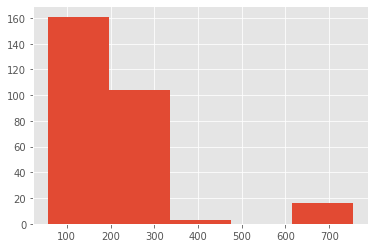

In [25]:
plt.hist([len(s) for s in train_texts], bins=5)
plt.show()

In [26]:
max([len(s) for s in train_texts]) # we will need truncation (automatically on token encodings and manually in the encode_labels function)

754

In [27]:
max([len(s) for s in test_texts])

733

Tokenization

In [28]:
from transformers import BertTokenizerFast, DistilBertTokenizerFast
print(tokenizer_name)
if 'dist' in tokenizer_name:
  tokenizer = DistilBertTokenizerFast.from_pretrained(tokenizer_name)
else:
  tokenizer = BertTokenizerFast.from_pretrained(tokenizer_name)

bert-base-cased


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [29]:
train_encodings = tokenizer(train_texts, padding=True, truncation=True)
dev_encodings = tokenizer(dev_texts, padding=True, truncation=True)
test_encodings = tokenizer(test_texts, padding=True, truncation=True)

### Dataset objects 

Create the dataset objects

In [30]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [31]:
# train_encodings.pop("offset_mapping") # we don't want to pass this to the model
# test_encodings.pop("offset_mapping")

In [32]:
train_dataset = MyDataset(train_encodings, train_labels)
dev_dataset = MyDataset(dev_encodings, test_labels)
test_dataset = MyDataset(test_encodings, test_labels)

### Training

Here, we instantiate the model

In [33]:
from transformers import DistilBertForSequenceClassification, BertForSequenceClassification
if 'dist' in MODELNAME:
  model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)
else:
  model = BertForSequenceClassification.from_pretrained(MODEL_PATH)

Some weights of the model checkpoint at /content/drive/My Drive/Colab Notebooks/BiodivBERT-NER/models/biodivbert-abstracts were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not ini

#### Fine-tuning using Trainer

In [34]:
from sklearn.metrics import accuracy_score
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    # print(labels)
    # print(predictions)
    # Remove ignored index (special tokens)
    # Create a long 1D list of y_true and y_pred
    y_true = []
    y_pred = []
    for pred, lbl in zip(predictions, labels):  
      y_true.append(lbl) 
      y_pred.append(pred)    
    acc = accuracy_score(y_true, y_pred)
    return {    # we can customize this dictionary to include Pr, Recall and F1-Score as well.
        "accuracy": acc,
    }

In [35]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=num_train_epochs,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy = "epoch",
    do_train=True,
    do_eval=True
  )

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset  
    eval_dataset=dev_dataset,           # evaluation dataset
    compute_metrics=compute_metrics,      
    
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 284
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 90


Epoch,Training Loss,Validation Loss,Accuracy
1,0.653300,0.608434,0.771429
2,0.596500,0.540340,0.771429
3,0.578900,0.530485,0.771429
4,0.487300,0.549734,0.771429
5,0.409500,0.589621,0.771429


***** Running Evaluation *****
  Num examples = 35
  Batch size = 64
***** Running Evaluation *****
  Num examples = 35
  Batch size = 64
***** Running Evaluation *****
  Num examples = 35
  Batch size = 64
***** Running Evaluation *****
  Num examples = 35
  Batch size = 64
***** Running Evaluation *****
  Num examples = 35
  Batch size = 64


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=90, training_loss=0.5537647088368733, metrics={'train_runtime': 38.0103, 'train_samples_per_second': 37.358, 'train_steps_per_second': 2.368, 'total_flos': 186079127238000.0, 'train_loss': 0.5537647088368733, 'epoch': 5.0})

### Save model

In [67]:
model.save_pretrained('{}_{}'.format(MODELNAME, DATASETNAME))

Configuration saved in biodivbert-abstracts_euadr/config.json
Model weights saved in biodivbert-abstracts_euadr/pytorch_model.bin


### Prediction

The use of validation dataset

In [37]:
eval_history = trainer.evaluate()

***** Running Evaluation *****
  Num examples = 35
  Batch size = 64


In [38]:
predictionsOutput = trainer.predict(test_dataset) 

***** Running Prediction *****
  Num examples = 35
  Batch size = 64


In [39]:
predictionsOutput.predictions.shape

(35, 2)

In [40]:
predictions = predictionsOutput.predictions.argmax(axis=1)

In [41]:
predictions.shape # each of the corresponding tokens has one label which has the highest propability

(35,)

Explore one example of the test dataset (prediction vs. true) lables.

In [42]:
for text, pred, lbl in zip(test_texts, predictions, test_labels):
  print(pred, text)
  print(lbl, text)
  break

1 @GENE$ is a calcification inhibitor and correlates negatively with increased @DISEASE$ in dialysis patients.
1 @GENE$ is a calcification inhibitor and correlates negatively with increased @DISEASE$ in dialysis patients.


### Evaluation Metrcies 

F1-Score, Precision and Recall, sklearn?

In [43]:
# Create a long 1D list of y_true and y_pred
y_true = []
y_pred = []

for text, pred, lbl in zip(test_texts, predictions, test_labels):
  y_true.append(lbl)
  y_pred.append(pred)

In [44]:
acc = accuracy_score(y_true, y_pred)
print(acc)

0.8571428571428571


In [45]:
from sklearn.metrics import precision_recall_fscore_support

In [46]:
precision_recall_fscore_support(y_true, y_pred,labels=[0,1])

(array([1.     , 0.84375]),
 array([0.375, 1.   ]),
 array([0.54545455, 0.91525424]),
 array([ 8, 27]))

In [47]:
from classification_metrics import classification_report

In [48]:
print(classification_report(y_true, y_pred,exclude_non_entity=True))

                        precision 	 recall 	 f1-score 	 support

                   0	 1.00		 0.38		 0.55		 8	
                   1	 0.84		 1.00		 0.92		 27	


macro avg           	 0.92		 0.69		 0.79		 35	
micro avg           	 0.86		 0.86		 0.86		 35	



### Visualizations
Plots of learning curves (loss and accuracy) during training and validation

In [49]:
def plot_dict(history, start_step=10,  step_size=10, use_title=None, use_xlabel=None, use_ylabel=None):
  plt.figure(figsize=(12,12))
  for key, list_val in history.items():
    plt.plot(list_val, label=key)
  plt.title(use_title)
  plt.xlabel(use_xlabel)
  plt.ylabel(use_ylabel, multialignment='center')
  plt.legend()
  plt.show()

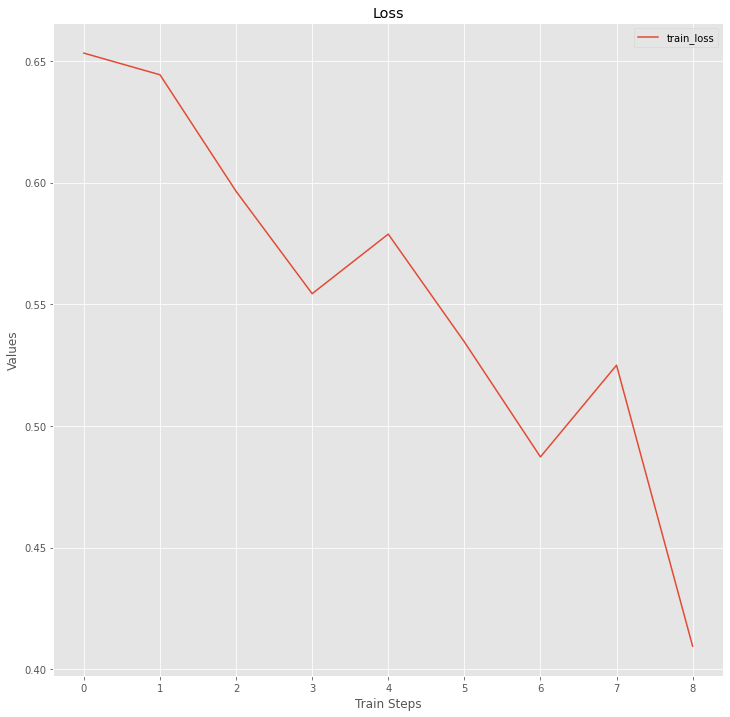

In [50]:
# Keep track of train and evaluate loss.
# loss_history = {'train_loss':[], 'eval_loss':[]}
loss_history = {'train_loss':[]}

# Keep track of train and evaluate accuracy
acc_history = {'train_acc':[], 'eval_acc':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:

  if 'loss' in log_history.keys():
    # Deal with trianing/eval loss.
    loss_history['train_loss'].append(log_history['loss'])
    #loss_history['eval_loss'].append(log_history['eval_loss'])
    
  elif 'acc' in log_history.keys():
    # Deal with training/eval accuracy.
    loss_history['train_acc'].append(log_history['acc'])
    loss_history['eval_acc'].append(log_history['eval_acc'])

# Plot Losses.
plot_dict(loss_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Loss', 
          use_xlabel='Train Steps', use_ylabel='Values')

In [51]:
eval_history

{'epoch': 5.0,
 'eval_accuracy': 0.7714285714285715,
 'eval_loss': 0.5896214246749878,
 'eval_runtime': 0.1861,
 'eval_samples_per_second': 188.105,
 'eval_steps_per_second': 5.374}

# Prediction

https://huggingface.co/docs/transformers/v4.17.0/en/task_summary#sequence-classification

In [52]:
model = BertForSequenceClassification.from_pretrained('{}_{}'.format(MODELNAME, DATASETNAME))
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

loading configuration file biodivbert-abstracts_euadr/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/My Drive/Colab Notebooks/BiodivBERT-NER/models/biodivbert-abstracts",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file biodivbert-abstracts_euadr/pytorch_model.bin
All model checkpoint weights were used when initial

In [53]:
sequence = 'Some @DISEASE$, relatively little research has compared the effects of various @GENE$'

In [54]:
classes = ["True", "False"]

In [55]:
true_sent = tokenizer(sequence, return_tensors="pt")

In [56]:
classification_logits = model(**true_sent).logits

In [57]:
results = torch.softmax(classification_logits, dim=1).tolist()[0]

In [58]:
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(results[i] * 100))}%")

True: 9%
False: 91%


In [59]:
classification_logits

tensor([[-1.2534,  1.1013]], grad_fn=<AddmmBackward0>)

In [60]:
sequence = 'Although COX-2 is commonly overexpressed in a variety of premalignant and malignant conditions including oral leukoplakia and @DISEASE$, relatively little research has compared the effects of various @GENE$ inhibitors (celecoxib, NS-398, nimesulide and meloxicam).'

In [61]:
classes = ["True", "False"]

In [62]:
true_sent = tokenizer(sequence, return_tensors="pt")

In [63]:
classification_logits = model(**true_sent).logits

In [64]:
results = torch.softmax(classification_logits, dim=1).tolist()[0]

In [65]:
for i in range(len(classes)):
    print(f"{classes[i]}: {int(round(results[i] * 100))}%")

True: 8%
False: 92%


In [66]:
classification_logits

tensor([[-1.3200,  1.1474]], grad_fn=<AddmmBackward0>)